In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind
warnings.simplefilter('ignore')
%matplotlib inline

In [56]:
user = pd.read_csv('user_table.csv', parse_dates = ['signup_date'])
user.head()

,user_id,signup_date
0,34,2015-01-01
1,59,2015-01-01
2,178,2015-01-01
3,285,2015-01-01
4,383,2015-01-01


In [57]:
test = pd.read_csv('test_table.csv', parse_dates = ['date'])
test.head()

,user_id,date,browser,test,pages_visited
0,600597,2015-08-13,IE,0,2
1,4410028,2015-08-26,Chrome,1,5
2,6004777,2015-08-17,Chrome,0,8
3,5990330,2015-08-27,Safari,0,8
4,3622310,2015-08-07,Firefox,0,1


In [58]:
user.isnull().sum()

user_id        0
signup_date    0
dtype: int64

In [59]:
test.isnull().sum()

user_id          0
date             0
browser          0
test             0
pages_visited    0
dtype: int64

In [60]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      100000 non-null  int64         
 1   signup_date  100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.5 MB


In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        100000 non-null  int64         
 1   date           100000 non-null  datetime64[ns]
 2   browser        100000 non-null  object        
 3   test           100000 non-null  int64         
 4   pages_visited  100000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 3.8+ MB


In [62]:
data = test.merge(user, on = 'user_id', how = 'left')
data.head()

,user_id,date,browser,test,pages_visited,signup_date
0,600597,2015-08-13,IE,0,2,2015-01-19
1,4410028,2015-08-26,Chrome,1,5,2015-05-11
2,6004777,2015-08-17,Chrome,0,8,2015-06-26
3,5990330,2015-08-27,Safari,0,8,2015-06-25
4,3622310,2015-08-07,Firefox,0,1,2015-04-17


In [96]:
#Ref: https://github.com/stasi009/TakeHomeDataChallenges/blob/master/17.EngagementTest/test_engagement.ipynb
def run_ttest(df):
    test = df.loc[data.test == 1, 'pages_visited']
    test_mean = test.mean()
    
    control = df.loc[data.test == 0, 'pages_visited']
    ctrl_mean = control.mean()
    
    result = ttest_ind(control, test, equal_var=False)
    conclusion = 'Significant' if result.pvalue < 0.05 else 'Not Significant'
    
    return pd.Series({'n_test':test.shape[0],
                      'n_ctrl': control.shape[0],
                      'mean_test': test_mean,
                      'mean_ctrl': ctrl_mean,
                      'test-ctrl': test_mean - ctrl_mean,
                      'pvalue':result.pvalue,
                      'conclusion':conclusion})

# Q1
Is the test winning? That is, should 100% of the users see the Recommended Friends
feature?

In [97]:
control = data[data['test'] == 0]
experiment = data[data['test'] == 1]

Null hypothesis: exp group has no difference with control group for num of pages visted

Alternative hypothesis： exp group has higher num of pages visted compared to control group

In [98]:
control['pages_visited'].mean()

4.608393853067447

In [99]:
experiment['pages_visited'].mean()

4.599692945727161

In [100]:
ttest_ind(a = control['pages_visited'], b = experiment['pages_visited'])

Ttest_indResult(statistic=0.5574592450809212, pvalue=0.5772149446386227)

P-value > 0.05, which means we cannot reject the null hypothesis, in here the p-value means that given the null hypothesis is true,the probability that we could observe what was in our result with our control and experiment data set is 0.5772149446386227: this value is really large, > 0.05, so we couldn't reject the null hypothesis.

So we shoudn't expand this feature to all users 100%

# Q2 
Is the test performing similarly for all user segments or are there differences among
different segments?

In [101]:
data['interval'] = (data['date'] - data['signup_date']).apply(lambda x: x.days)
data['new_user'] = (data['interval'] == 0).astype(int)
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)
data.head()

,user_id,date,browser,test,pages_visited,signup_date,interval,new_user,dayofweek
0,600597,2015-08-13,IE,0,2,2015-01-19,206,0,3
1,4410028,2015-08-26,Chrome,1,5,2015-05-11,107,0,2
2,6004777,2015-08-17,Chrome,0,8,2015-06-26,52,0,0
3,5990330,2015-08-27,Safari,0,8,2015-06-25,63,0,3
4,3622310,2015-08-07,Firefox,0,1,2015-04-17,112,0,4


# Browser

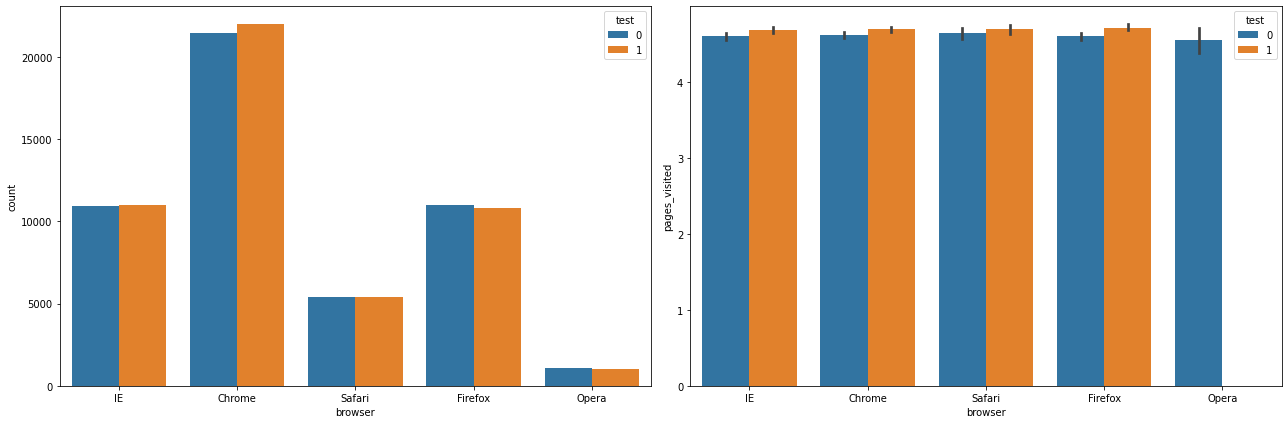

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', hue='test', data=data, ax=ax[0])
sns.barplot(x='browser', y='pages_visited', hue='test', data=data, ax=ax[1])
plt.tight_layout()
plt.show()

In [104]:
data.groupby('browser').apply(run_ttest)

,n_test,n_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
browser,,,,,,,
Chrome,21974,21453,4.690680,4.613341,0.077339,9.434084e-04,Significant
Firefox,10786,10972,4.714259,4.600164,0.114095,5.817199e-04,Significant
IE,10974,10906,4.685985,4.598478,0.087507,7.829509e-03,Significant
Opera,1018,1109,0.000000,4.546438,-4.546438,2.252939e-321,Significant
Safari,5402,5406,4.692336,4.638180,0.054156,2.411738e-01,Not Significant


# New user

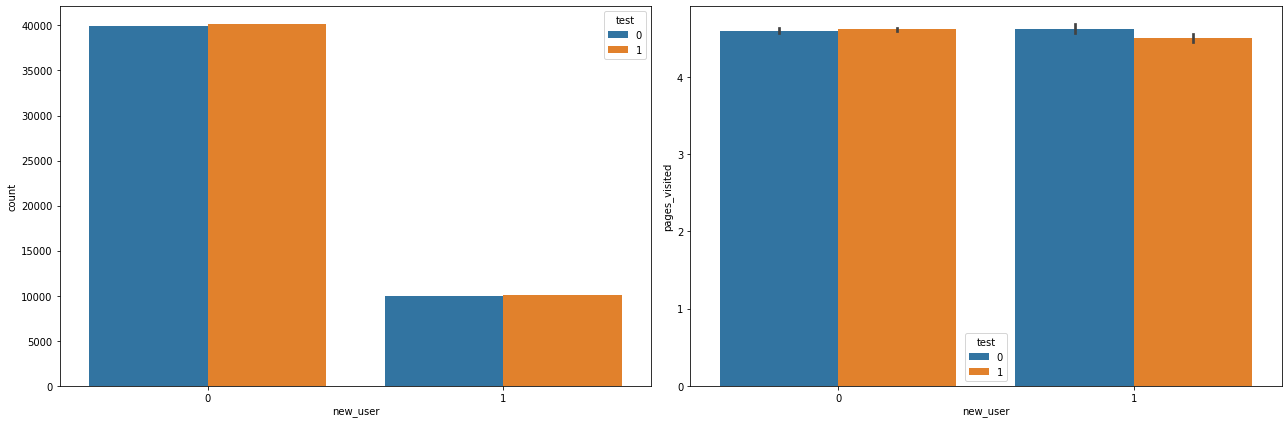

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='test', data=data, ax=ax[0])
sns.barplot(x='new_user', y='pages_visited', hue='test', data=data, ax=ax[1])
plt.tight_layout()
plt.show()

In [105]:
data.groupby('new_user').apply(run_ttest)

,n_test,n_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
new_user,,,,,,,
0,40109,39890,4.622379,4.603284,0.019095,0.261837,Not Significant
1,10045,9956,4.509109,4.628867,-0.119758,0.001742,Significant


# Day of the week

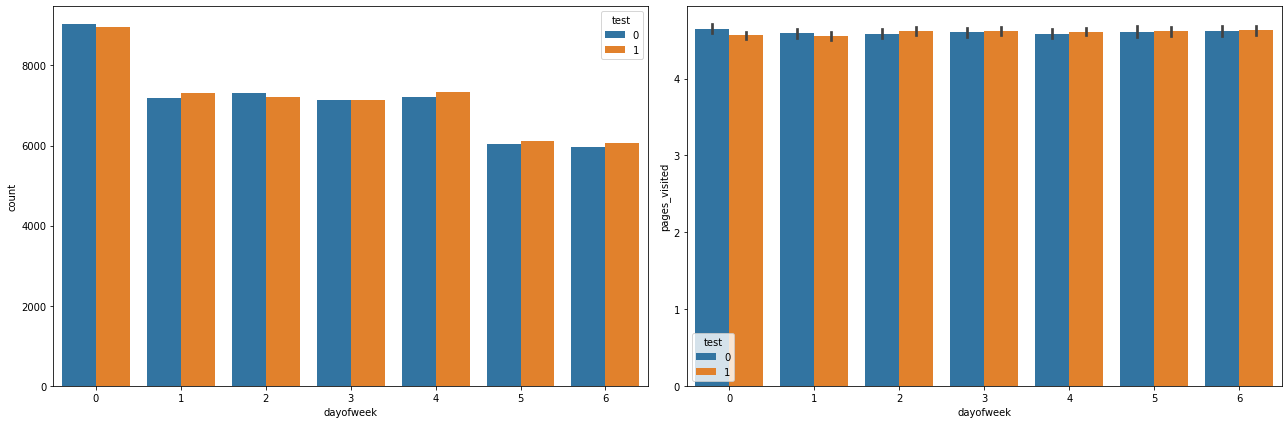

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='dayofweek', hue='test', data=data, ax=ax[0])
sns.barplot(x='dayofweek', y='pages_visited', hue='test', data=data, ax=ax[1])
plt.tight_layout()
plt.show()

In [106]:
data.groupby('dayofweek').apply(run_ttest)

,n_test,n_ctrl,mean_test,mean_ctrl,test-ctrl,pvalue,conclusion
dayofweek,,,,,,,
0,8969,9023,4.563942,4.650781,-0.086839,0.017818,Significant
1,7313,7186,4.552851,4.591845,-0.038994,0.337859,Not Significant
2,7216,7318,4.617932,4.585816,0.032117,0.430152,Not Significant
3,7138,7138,4.622723,4.604091,0.018633,0.654807,Not Significant
4,7328,7202,4.612309,4.586643,0.025666,0.529504,Not Significant
5,6120,6026,4.615033,4.613010,0.002022,0.964417,Not Significant
6,6070,5953,4.629489,4.618680,0.010810,0.811739,Not Significant



For new user, this new feature decrease the num_visted_pages, and the results is significant.

For different browser, except for the browser, the Opera browser did not have any experiment responses, any other browser than safari, have a increase in num of page visited with the new feature

For the day of the week, it seem like this features is significant on monday.

In [107]:
data.groupby(['browser','new_user']).apply(run_ttest)

n_test  n_ctrl  mean_test  mean_ctrl  test-ctrl  \
browser new_user                                                    
Chrome  0          17525   17092   4.701512   4.607945   0.093567   
        1           4449    4361   4.648011   4.634488   0.013523   
Firefox 0           8657    8842   4.757306   4.590590   0.166716   
        1           2129    2130   4.539220   4.639906  -0.100686   
IE      0           8779    8744   4.721494   4.590576   0.130918   
        1           2195    2162   4.543964   4.630435  -0.086471   
Opera   0            833     883   0.000000   4.594564  -4.594564   
        1            185     226   0.000000   4.358407  -4.358407   
Safari  0           4315    4329   4.720973   4.638254   0.082720   
        1           1087    1077   4.578657   4.637883  -0.059226   

                         pvalue       conclusion  
browser new_user                                  
Chrome  0          2.290889e-04      Significant  
        1          8.149175e-01  Not Significant  
Firefox 0          3.692901e-06      Significant  
        1          2.210706e-01  Not Significant  
IE      0          2.669847e-04      Significant  
        1          2.808421e-01  Not Significant  
Opera   0         7.204927e-255      Significant  
        1          1.222949e-68      Significant  
Safari  0          1.000829e-01  Not Significant  
        1          6.015241e-01  Not Significant

For the combined segments between browser and new user, we could see that for old user, the results is consistent with what we have for the browser individually. 

However for the old user, we could see a drop in the num of pages visited with this feature, maybe because this new model will recommand friends based on their past history of the social feeds and activity ,and new user might not have them.
This is also called a 'cold start' problem.

# Q3
If you identified segments that responded differently to the test, can you guess the
reason? Would this change your point 1 conclusions?

In [71]:
subset = data[data['browser'] != 'Opera'] 

In [73]:
subset['browser'].value_counts()

Chrome     43427
IE         21880
Firefox    21758
Safari     10808
Name: browser, dtype: int64

In [76]:
subset.groupby('test')['pages_visited'].mean()

test
0    4.609804
1    4.694989
Name: pages_visited, dtype: float64

In [77]:
control = subset[subset['test'] == 0]
experiment = subset[subset['test'] == 1]

In [78]:
ttest_ind(a = control['pages_visited'], b = experiment['pages_visited'])

Ttest_indResult(statistic=-5.479595897076519, pvalue=4.273456891094664e-08)

Now the p-value 4.273456891094664e-08, which is less than 0.05. So, we can safely reject null hypothesis and expand this feature to the whole user base.